===================================================
### Code developed by: Yushen Lin and Jin Yu

### Contact: yl2020@ic.ac.uk, jin.yu20@imperial.ac.uk
===================================================

## Table of content:
* [Space filling curve](#first-bullet)
* [Convolutional autoencoder](#second-bullet)

# Import Required Libraries 

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/dimension reduction')

In [ ]:
!pip install vtk -q
!pip install livelossplot -q
!pip install cmocean -q
!pip install meshio -q

mesh = meshio.read(filename,  # string, os.PathLike, or a buffer/open file

file_format="stl",  # optional if filename is a path; inferred from extension

mesh.points, mesh.cells, mesh.cells_dict, ...

In [ ]:
!python -m numpy.f2py -c space_filling_decomp_new.f90 -m space_filling_decomp_new

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import os
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import gzip
import vtk
import vtktools

import space_filling_decomp_new as sfc
import sys, os
import datetime, time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

import platform

import glob
import progressbar
import meshio
import cmocean
import joblib

# Space filling curve  <a name='first-bullet'></a>

Space filling curves are one-dimensional(1D) orederings which traverse every single data in the multi-dimensional space one time, and it reorders data in multi-dimensional space that maps to 1D space.

SFCs produce a continuous curve through a finite element mesh, in
which the curve traverses every node of the mesh.

In [ ]:
# comment this to enable interactive mode
path = '/content/gdrive/MyDrive/dimension reduction/SFC example'
os.chdir(path)
import matplotlib
matplotlib.use('AGG')

import numpy as np
import matplotlib.pyplot as plt
import os

def apply_rules(s):
  """ Hilbert Curve as a Lindenmayer system (L-system)
  https://en.wikipedia.org/wiki/Hilbert_curve#Representation_as_Lindenmayer_system
  
  Here, "F" means "draw forward", "+" means "turn left 90°", 
  "-" means "turn right 90°" (see turtle graphics), 
  and "A" and "B" are ignored during drawing."""

  s=s.replace("a","-Bf+AfA+fB-")  # capital letters "A" and "B" so that the second operation
  s=s.replace("b","+Af-BfB-fA+")  # doesn't apply to the changes already made
  return s.lower() # make everyone lowercase

axiom = "a"
n=5 # number of iterations
# displacements, ordered in a counter-clockwise direction
dxdy = np.array([[ 1, 0],    # right
          [ 0, 1],    # up
          [-1, 0],    # left
          [ 0,-1] ])  # down
# displacement is of size 1, so the higher n is, the greater the domain
length = 2**n-1; margin = 0.05*length
domain = [0-margin,length+margin,0-margin,length+margin] # a 5% margin around the curve
s = axiom # string to iterate upon

for i in np.arange(n):
  s = apply_rules(s)

make_movie=True
plt.ion() # interactive mode disabled if "matplotlib.use('AGG')"
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.axis('off')                        # no frame
ax.axis(domain)                       # domain size
ax.set_aspect('equal')                # square look
ax.set_xticks([]); ax.set_yticks([])  # no ticks
ax.set_title(r"$n = {:d}$".format(n))
# plt.show()

# "a" and "b" can be erased now
s=s.replace("a","")
s=s.replace("b","")

frame_names = []  # these two are only relevant if make_movie==True
frame_counter=0

p = np.array([[0.0,0.0]]) # this is the starting point (0,0)
p_plot, = plt.plot(p[:,0],p[:,1],color="black")

# iterate on the string s
for i,c in enumerate(s):
  # uncomment to see how fast things are going
  # print("{:d}/{:d}".format(i,len(s)))
  
  # rotations "+" and "-" change the displacement array dxdy
  # "+" means clockwise rotation
  if c == '+': dxdy = np.roll(dxdy,+1,axis=0)
  # "-" means counter-clockwise rotation
  if c == '-': dxdy = np.roll(dxdy,-1,axis=0)
  # forward "f"
  if c == 'f':
    # add one more point to array p
    p = np.vstack([p, [p[-1,0]+dxdy[0,0],p[-1,1]+dxdy[0,1]] ])
    # update p_plot data, this is MUCH faster that plotting
    # several line segments separately
    p_plot.set_data(p[:,0],p[:,1])
    fig.canvas.draw()
    if make_movie:
      fname = "_tmp{:05d}.png".format(frame_counter)
      frame_names.append(fname)
      fig.savefig(fname,bbox_inches='tight',resolution=300)
    frame_counter += 1
    

full_tensor: The tensor of all vtu_fields you specified for all snapshots in the {data_path}, 3-dimension, the first dimension is number of snapshots in that {data_path}, the second is the number of Nodes in each snapshots, the last is number of components in the vtu_fields, for example, in this FPC test case, two components for Velocity, one for Pressure.

coords: The coordinates of the unadapted mesh Nodes from the vtu file, 3-dimension.

## Plot the contour

In [ ]:
def countour_plot_vtu_2D(coords, levels, values=None, cmap = None):
    '''
    This function plots the contour of a 2D unstructured mesh based on a coordinate sequence.
    Input:
    ---
    coords: [2d-array] of shape(number of Nodes, 2/3), suggest to combine it with space-filling orderings, e.g. coords[sfc_ordering].
    levels: [int] the levels of colormap for the plot.
    mask: [bool] mask the cylinder, only turn it on for the 'Flow Past Cylinder' Case.
    Values: [1d-array] of shape(number of Nodes, ), default is Node indexing, suggest you will use this for plotting scalar field? Not suggested, too slow.
    cmap: [camp object] a custom cmap like 'cmocean.cm.ice' or an official colormap like 'inferno'.
    Output:
    ---
    NoneType: the plot.
    '''
    x = coords[:, 0]
    y = coords[:, 1]
    x_left = x.min()
    x_right = x.max()
    y_bottom = y.min()
    y_top = y.max()
    y_scale = (y_top - y_bottom) / (x_right - x_left)
    fig, ax = plt.subplots(figsize=(40, 40 * y_scale))
    ax.set_xlim(x_left, x_right)
    ax.set_ylim(y_bottom, y_top)
    
    triang = tri.Triangulation(x, y)

    if values == None:
        values=np.arange(coords.shape[0])
    

    plt.tricontourf(triang, values, levels = levels, cmap = cmap)    
    plt.axis('off')
    plt.show()  

## Train, validation and test dataset initialisation

In [ ]:
from structured import *
from training import *
from util import *
from sfc_cae import *

In [ ]:
# data path might be changed if you want to import in your own dir
data_path = 'ClarenceData/'
vtu_fields = ['CO2_ppm', 'Velocity'] # vtu fields you want to export
full_tensor, coords, cells = read_in_files(data_path, vtu_fields = vtu_fields)

In [ ]:
#torch.save(full_tensor, '/content/gdrive/MyDrive/CO2_V.pt')
#torch.save(coords, '/content/gdrive/MyDrive/CO2_mesh_V.pt')

In [ ]:
full_tensor = torch.load('/content/gdrive/MyDrive/CO2_V.pt').float()
coords = torch.load('/content/gdrive/MyDrive/CO2_mesh_V.pt')
full_tensor.shape

torch.Size([455, 148906, 4])

In [ ]:
# use ncurve_python_subdomain_space_filling_curve provided in fortran code to calculate space_filling_orederings
ncurves = 3  # specify space-filling curve numbers
data_path = 'ClarenceData/'
template_vtu = vtktools.vtu(glob.glob(data_path + '*')[0])
space_filling_orderings, invert_space_filling_orderings = get_sfc_curves_from_coords_CG(coords, ncurves,template_vtu)
print(space_filling_orderings)
grid_search_load = space_filling_orderings

[array([ 4185,  4184,  9563, ..., 29697, 24826, 32895]), array([53488, 53489, 53491, ..., 28842, 38661, 34065]), array([37732, 30853, 23924, ..., 66746, 66187, 61376])]
[array([ 4185,  4184,  9563, ..., 29697, 24826, 32895]), array([53488, 53489, 53491, ..., 28842, 38661, 34065]), array([37732, 30853, 23924, ..., 66746, 66187, 61376])]


In [ ]:
#torch.save(space_filling_orderings, '/content/gdrive/MyDrive/CO2_sfc.pt')
#torch.save(invert_space_filling_orderings, '/content/gdrive/MyDrive/CO2_invsfc.pt')

In [ ]:
# load space_filling_orderings for the autoencoder to map the data
space_filling_orderings = list(torch.load('/content/gdrive/MyDrive/CO2_sfc.pt'))
invert_space_filling_orderings = list(torch.load('/content/gdrive/MyDrive/CO2_invsfc.pt'))

In [ ]:
#visualize the space-filling curve on a 2D plane
countour_plot_vtu_2D(coords[space_filling_orderings[2]], 20)

In [ ]:
# split the train, valid and test data set as 8:1:1
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1 
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = full_tensor.shape[0])
full_set, k, b = standardlize_tensor(full_tensor, lower = -1, upper = 1)

train_set = full_set[train_index - 1]
valid_set = full_set[valid_index - 1]
test_set = full_set[test_index - 1]

valid_batch_size = valid_set.shape[0]
test_batch_size = test_set.shape[0]

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=valid_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=True)

In [ ]:
print(k.detach().numpy())
b.detach().numpy()

[1.8421940e-03 7.6536483e-01 2.0014703e+00 2.1555524e+00]


array([-1.730393  , -0.5493109 ,  0.49897358, -0.00207802], dtype=float32)

#Convolutional autoencoder <a name='second-bullet'></a>

## Indicate the parameters for the **autoencoder**

`input_size` is the number of Nodes, e.g. 148906 <br> `dimension` is the dimension of the data in Vtu files, e.g. 3 including CO2 and Velocity fields.<br> `components` is the number of components that will be compressed, if the tensor is 2 dimension, then it is default of 1. `self_concat` is channel copying operation, you could keep it default as 1, or 2 when you have multiple SFCs. <br> `structured`: bool, whether you are training SFC-CAE on a structured mesh or not.<br>`nearest_neighboring`: bool, adding sparse layers or not, suggest to turn on.<br>
`dims_letent`: The dimension of the compressed data after applying decoder. <br>
`space_filling_orderings`, `invert_space_filling_orderings` : lists of sfc\inverse_sfc nums, generated by `get_sfc_curves_from_coords` function, or read the orderings from a `csv` file on your own. <br>
`activation`: Can be customly defined, but if you not spcify, the activation would be `ReLU()` for structured mesh, and `Tanh()` for unstructured mesh.

In [ ]:
input_size = train_set.shape[1]
dimension = 3 # CO2 and velocity feild
components = full_tensor.shape[-1]
self_concat = 2
structured = False
nearest_neighbouring = True # set this to Flase will result in slightly poorer performance, but a quicker training speed
dims_latent = 1 # bottleneck layer you want to compress
activation = nn.Tanh() # nn.LeakyReLU() nn.Relu()
variational = False

In [ ]:
# define the autoencoder based on the settings above
autoencoder = SFC_CAE(input_size,
             dimension,
             components,
             structured,
             self_concat,
             nearest_neighbouring,
             dims_latent,
             space_filling_orderings, 
             invert_space_filling_orderings,
             activation,
             variational = variational)

In [ ]:
# basd on trial observations (tested on batch_size 8,16,32,64,128) we final choose 16 and lr at 1e-3
batch_size = 16
seed = 42
lr = 1e-3
n_epochs = 2000
weight_decay = 0
optimizer = 'Adamax' # we tested Adam, Nadam, SGD-momentum, finally Adamax is chosen as it provides better performance generally
criterion_type = 'MSE' # mean squared error

In [ ]:
# check the interface of the wrapper to see if there is anything missing
from inspect import signature
sig = signature(train_model)
str(sig)

"(autoencoder, train_loader, valid_loader, test_loader, optimizer='Adamax', state_load=None, n_epochs=100, varying_lr=False, check_gap=3, lr=0.0001, weight_decay=0, criterion_type='MSE', visualize=True, seed=41, save_path=None)"

In [ ]:
print(train_loader.dataset.shape)
full_tensor.shape

torch.Size([364, 148906, 4])


torch.Size([455, 148906, 4])

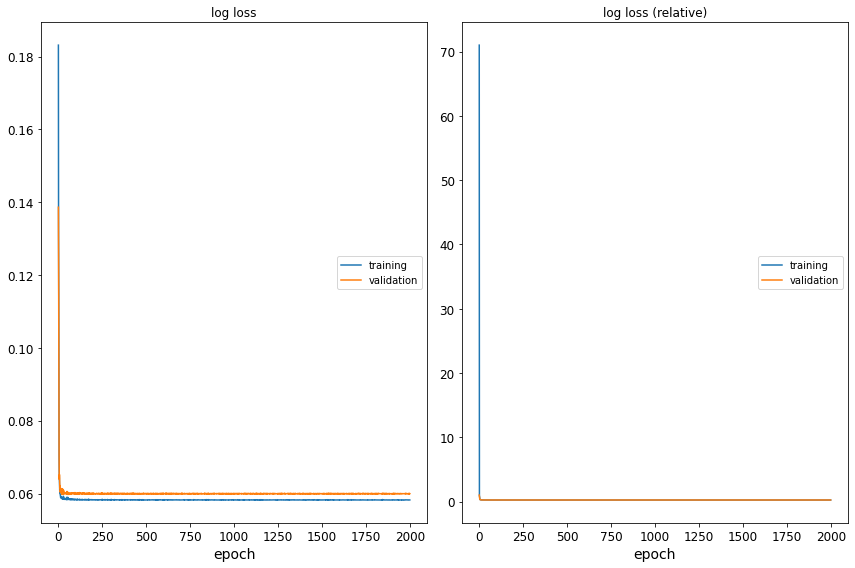

log loss
	training         	 (min:    0.058, max:    0.183, cur:    0.058)
	validation       	 (min:    0.060, max:    0.139, cur:    0.060)
log loss (relative)
	training         	 (min:    0.251, max:   71.004, cur:    0.252)
	validation       	 (min:    0.252, max:    1.020, cur:    0.261)
Epoch:  1999 | train loss: 5.823331e-02 | valid loss: 5.996915e-02 
      	| train loss (relative): 2.522452e-01 | valid loss (relative): 2.609400e-01 
Epoch 1999 use: 8.30 second.

test MSE Error: 6.759465e-02 | relative MSE Error: 2.941205e-01 
 Total time used for training: 4.61 hour.


In [ ]:
# this is the case when dim is compressed to 1
# train, validation and test data is pre-defined in the previous cells and the varibles are defined above
autoencoder = train_model(autoencoder, 
               train_loader = train_loader,
               valid_loader = valid_loader,
               test_loader = test_loader,
               optimizer=optimizer,
               n_epochs = n_epochs, 
               lr = lr,
               weight_decay = weight_decay,
               criterion_type = criterion_type,
               visualize = True,
               seed = seed)

In [ ]:
test_reconstruct = autoencoder.to('cpu')(test_set)
print('test MSE loss: %e' % nn.MSELoss()(test_set, test_reconstruct).item())

test MSE loss: 6.759465e-02


In [ ]:
# dump the autoencoder and use it later in the PredGAN
joblib.dump(autoencoder, "autoencoder_py_1.pkl")

['autoencoder_py_1.pkl']

In [ ]:
autoencoder = joblib.load("autoencoder_py_43.pkl")

# Result to vtu files

In [ ]:
# added functions to output vtu files from reconstruct
data_path = 'ClarenceData/'
save_path = 'ClarenceData/Predictions/dimension_1'
vtu_fields = ['CO2_ppm', 'Velocity']
model_device = torch.device('cuda')
autoencoder = autoencoder.to(model_device)
result_vtu_to_vtu(data_path,save_path, vtu_fields, autoencoder, k.detach().numpy(), b.detach().numpy(), model_device = model_device)

In [ ]:
# rotate the pic for report
from google.colab.patches import cv2_imshow
import cv2
import imutils
image = cv2.imread(r"/content/gdrive/MyDrive/dimension reduction/SFC-CAE/SFC-CAE-main/contunr_SFC_ordering.png")
 
rot = imutils.rotate(image, angle=20)
cv2_imshow(rot)
cv2.waitKey(0)